# Ch8. 운영 위험 모델림

- 운영 위험: 부적절 or 실패한 구간 프로세스, 인력, 시스템 or 외부 이벤트로 인한 직간접적인 손실 위험
- 직접비용 ex: 법적 책임 / 절도 or 자산 감소(상각) / 세금, 라이선스, 벌금 등 / 업무 중단
- 간접비용: 기관의 결정이 미래의 불확실한 시기에 손실을 초래하는 일련의 사건을 유발할 수 있다는 점에서 기회 비용과 관련 있음
- generally, 금융기관: 운용 위험에 따른 손실 충당 위해 일정 금액의 자금을 할당함 -> 미예상 손실
- but 적절 할당 어렵; too much: 유휴 상태 ~ 기회 비용 발생 / too little: 유동성 문제
- in this chapter, 사기 or 사기 가능성이 있는 작업을 감지하는 ML 기반 모델 소개 w/ 신용카드 거래 사기 탐지 데이터셋
$\\ \rarr$ 사기 가능성 감지 & 은행이 실사 통해 상황을 조사할 수 있도록 은행에 알림: 은행이 막대한 손실을 입지 않도록 보호함

In [1]:
!pip install kagglehub


   ---------------------------------------- 0/2 [kagglesdk]
   ---------------------------------------- 0/2 [kagglesdk]
   ---------------------------------------- 0/2 [kagglesdk]
   ---------------------------------------- 0/2 [kagglesdk]
   ---------------------------------------- 0/2 [kagglesdk]
   ---------------------------------------- 0/2 [kagglesdk]
   ---------------------------------------- 0/2 [kagglesdk]
   -------------------- ------------------- 1/2 [kagglehub]
   -------------------- ------------------- 1/2 [kagglehub]
   ---------------------------------------- 2/2 [kagglehub]



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [6]:
fraud_data=pd.read_csv('fraudTrain.csv')
del fraud_data['Unnamed: 0']

In [7]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


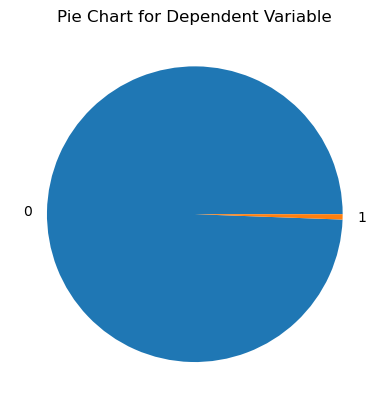

In [ ]:
plt.pie(fraud_data['is_fraud'].value_counts(), labels=[0,1]) # 거래의 사기성 여부
plt.title('Pie Chart for Dependent Variable')
print(fraud_data['is_fraud'].value_counts())
plt.show() # 불균형적 관찰 수 ~ "데이터의 불균형"

In [10]:
!pip install missingno

<Axes: >

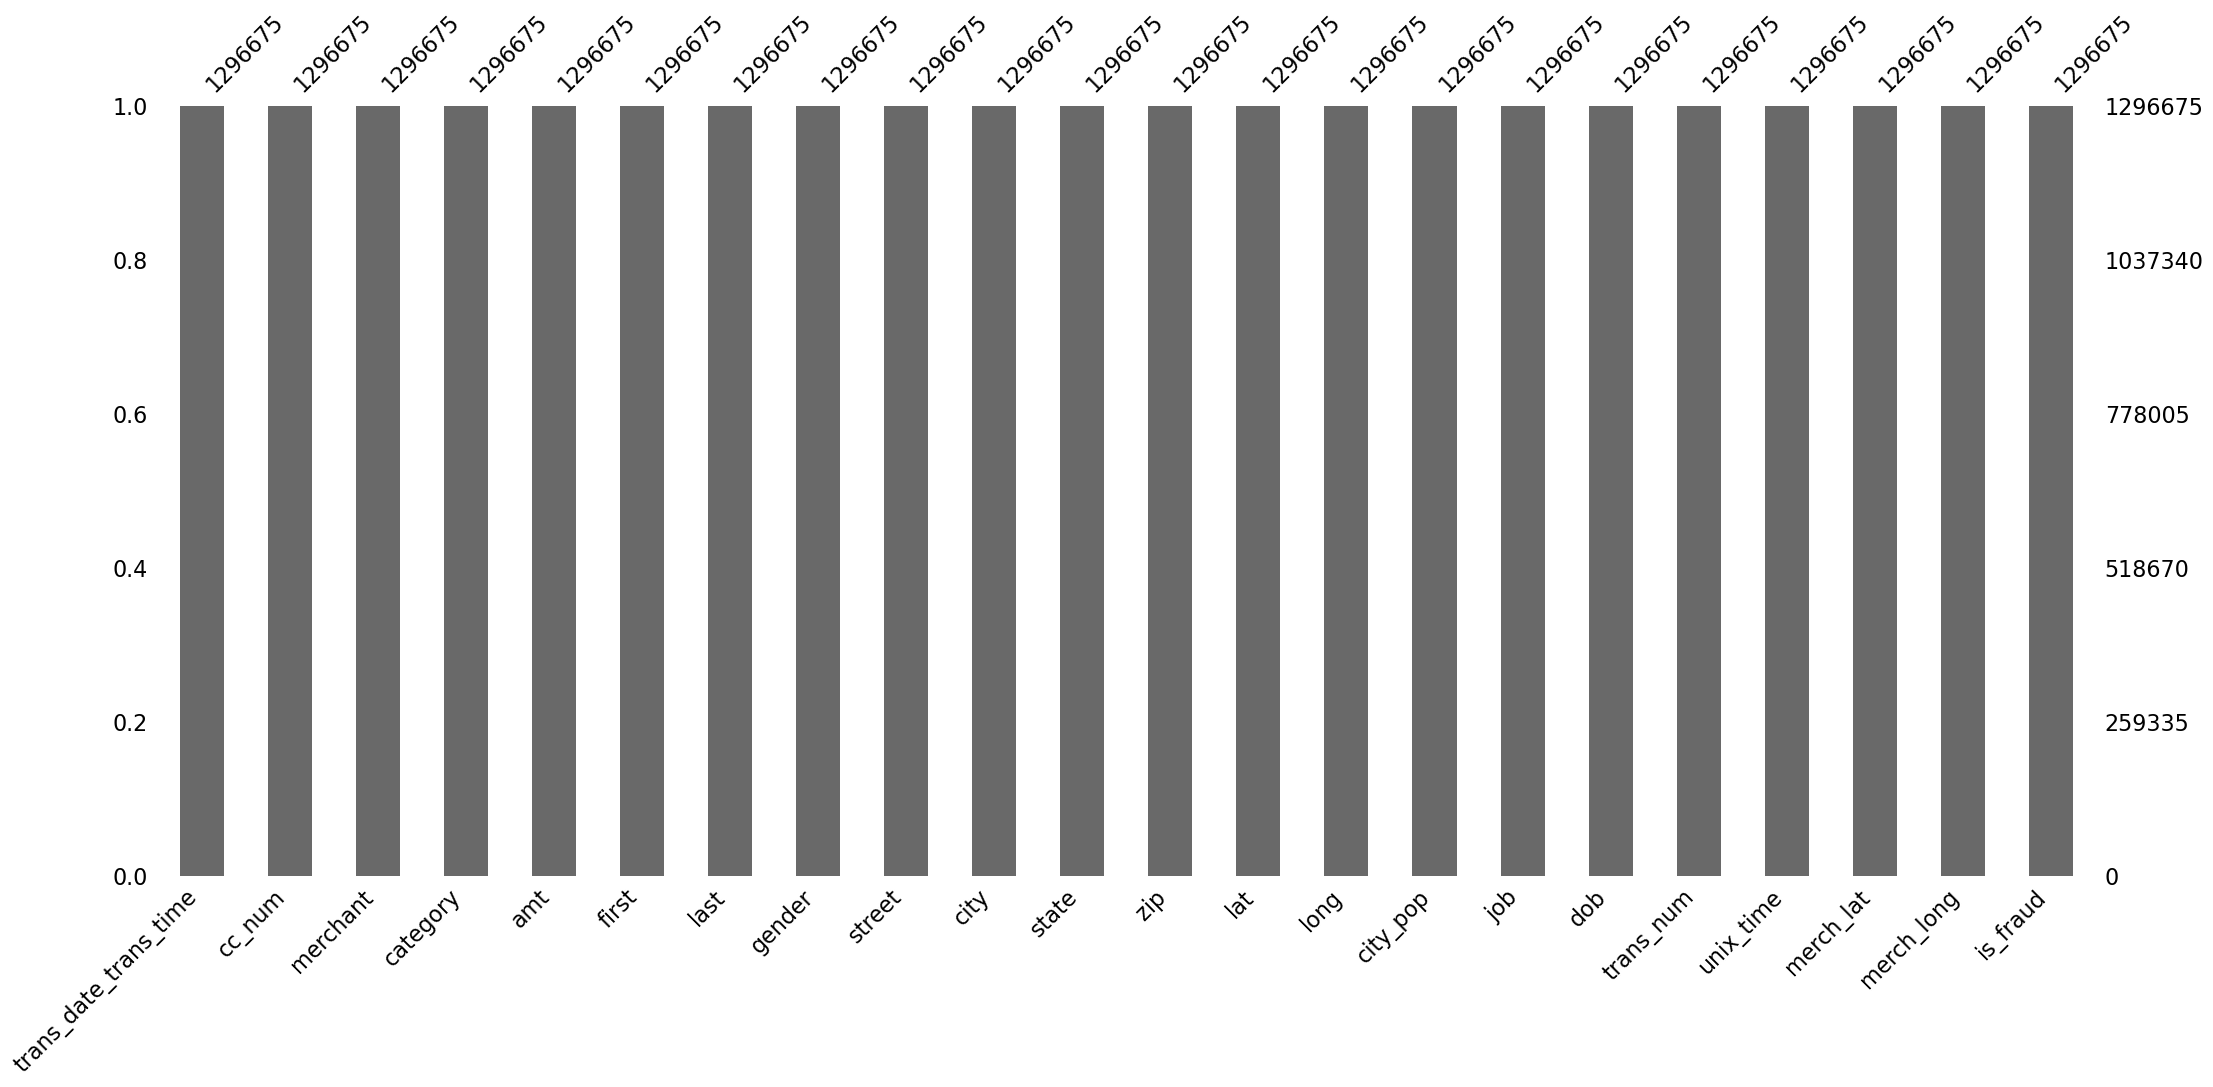

In [ ]:
# 누락된 값에 대한 시각화 모듈
import missingno as msno
msno.bar(fraud_data) # 상단에 변수당 비결측 관측값의 수 나타냄, 왼쪽에는 비결측값의 백분율 ~ 결측값 없음

In [12]:
# 특정 기간 동안 사기 행위가 급증한다고 가정해 시간을 날짜 & 시간으로 나눔
fraud_data['time']=pd.to_datetime(fraud_data['trans_date_trans_time'])
del fraud_data['trans_date_trans_time']

fraud_data['days']=fraud_data['time'].dt.day_name()
fraud_data['hour']=fraud_data['time'].dt.hour

In [19]:
def fraud_cat(cols):
    k=1
    plt.figure(figsize=(20,40))
    for i in cols:
        categ=fraud_data.loc[fraud_data['is_fraud']==1, i].value_counts().sort_values(ascending=False).reset_index().head(10)
        plt.subplot(int(len(cols)/2), int(len(cols)/2), k)
        bar_plot=plt.bar(categ.iloc[:,0],categ[i])
        plt.title(f'Cases per {i} Categories')
        plt.xticks(rotation=45)
        k+=1
    return categ, bar_plot

<BarContainer object of 10 artists>

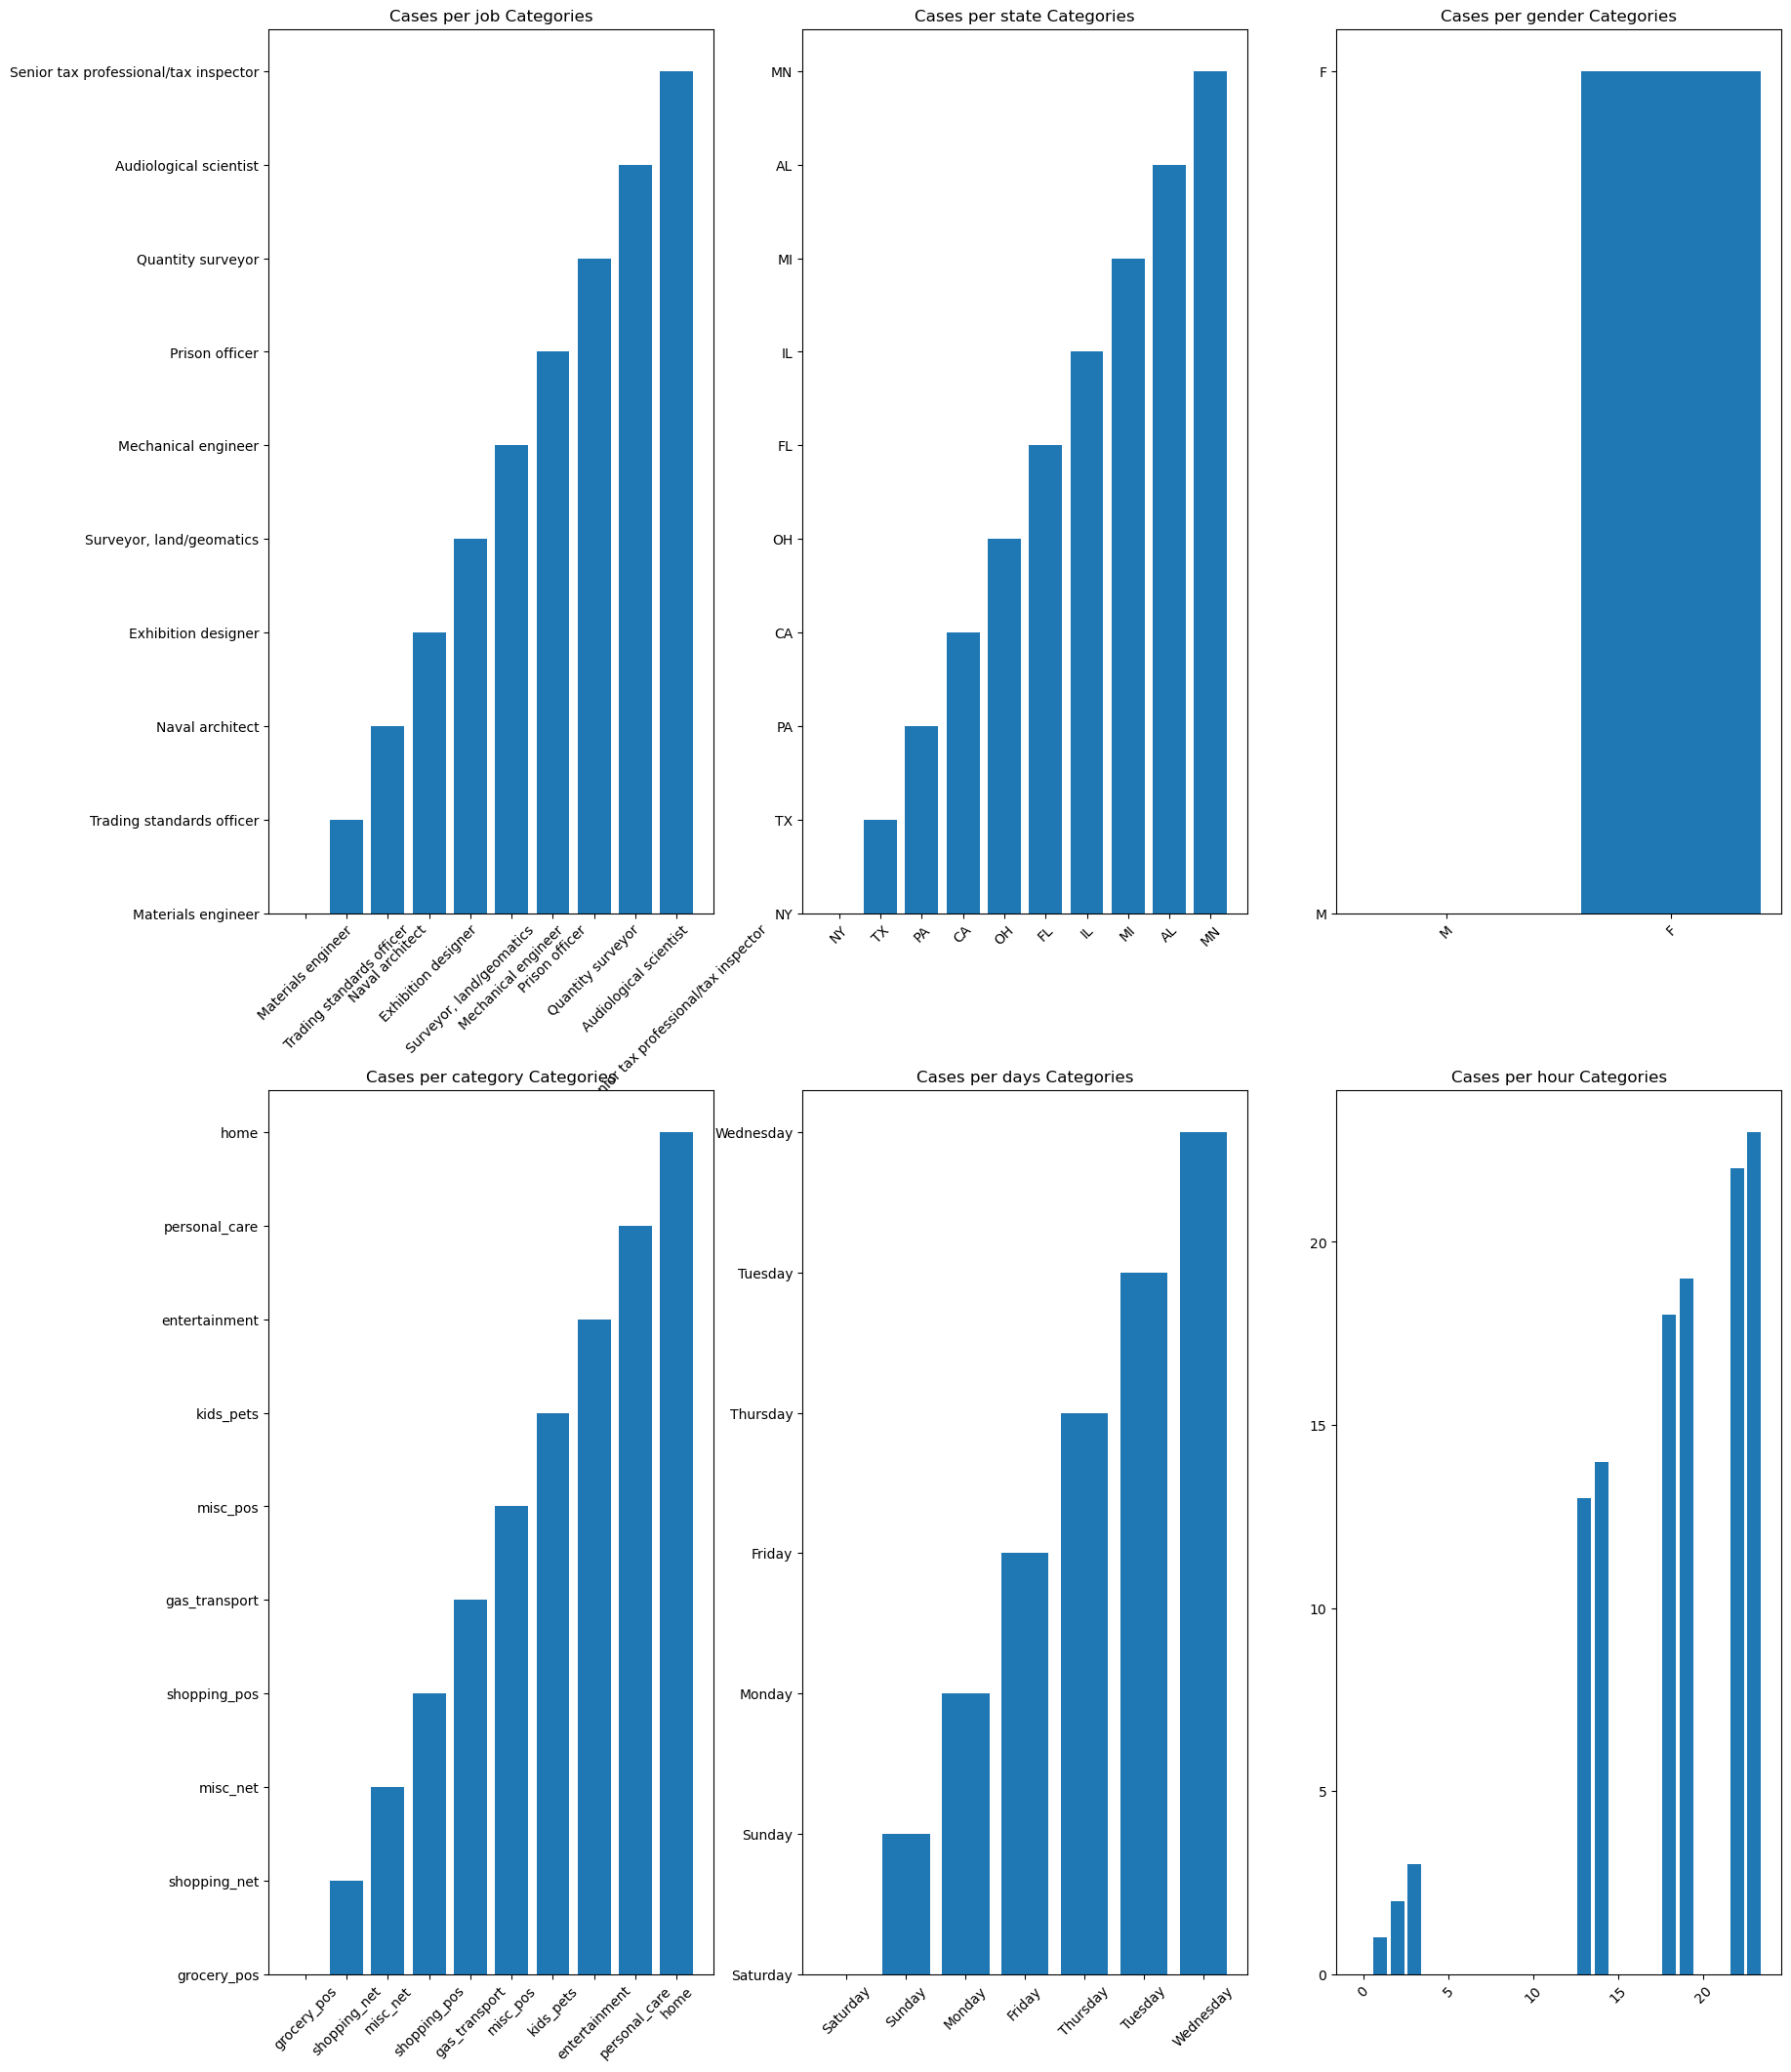

In [20]:
cols=['job','state','gender','category','days','hour']
_, bar_plot=fraud_cat(cols)
bar_plot

In [21]:
cols=['amt','gender','state','category','city_pop','job','is_fraud','days','hour']
fraud_data_df=fraud_data[cols]

In [22]:
cat_cols=fraud_data_df.select_dtypes(include='object').columns

def one_hot_encoded_cat(data, cat_cols):
    for i in cat_cols:
        df1=pd.get_dummies(data[str(i)], prefix=i, drop_first=True)
        data.drop(str(i), axis=1, inplace=True)
        data=pd.concat([data, df1], axis=1)
    return data

In [23]:
fraud_df=one_hot_encoded_cat(fraud_data_df, cat_cols)

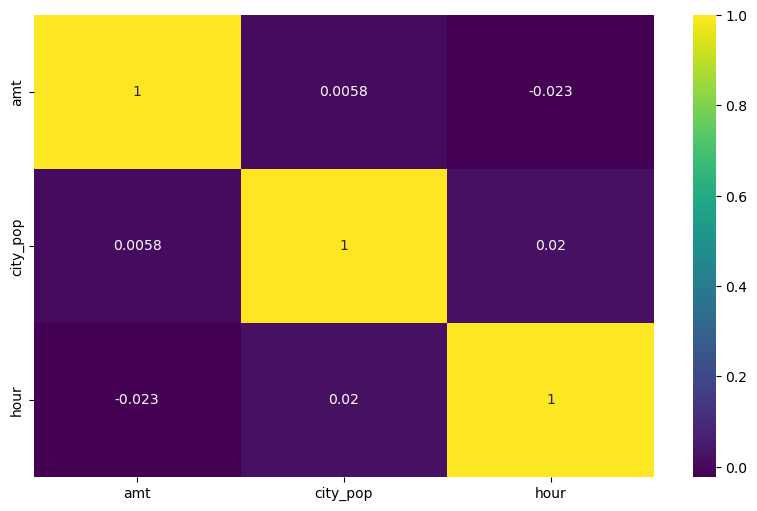

In [27]:
# 변수들 간의 상호작용 ~ 상관관계
num_col=fraud_data_df.select_dtypes(exclude='object').columns
fraud_data_df=fraud_data_df[num_col]
#del fraud_data_df['is_fraud']

plt.figure(figsize=(10,6))
corrmat=fraud_data_df.corr()
top_corr_features=corrmat.index
heat_map=sns.heatmap(corrmat, annot=True, cmap='viridis')

(\*) 사기 조사를 위한 지도 학습
- 모델 수행 전 균형 잡힌 데이터 갖는 것이 중요함
- 언더샘플링 실시: 다수 부류를 소수 부류에 일치시킴
- 소수 부류와 동일한 수의 관측값을 얻을 때까지 다수 부류의 관측값 수를 제거함

In [28]:
from sklearn.model_selection import train_test_split # 임의로 train과 test split 실시
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, f1_score)

In [29]:
non_fraud_class=fraud_df[fraud_df['is_fraud']==0]
fraud_class=fraud_df[fraud_df['is_fraud']==1]

non_fraud_count, fraud_count=len(non_fraud_class), len(fraud_class)
print('The number of observations in non_fraud_class:', non_fraud_count)
print('The number of observations in fraud_class:', fraud_count)

The number of observations in non_fraud_class: 1289169
The number of observations in fraud_class: 7506


In [30]:
non_fraud_under=non_fraud_class.sample(fraud_count) # 샘플링
under_sampled=pd.concat([non_fraud_under, fraud_class],axis=0)
X_under=under_sampled.drop('is_fraud',axis=1)
y_under=under_sampled['is_fraud']

In [31]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, random_state=0)

In [ ]:
# 로지스틱 회귀
param_log={'C':np.logspace(-4,4,4), 'penalty':['l1','l2']}
log_grid=GridSearchCV(LogisticRegression(), param_grid=param_log, n_jobs=1)
log_grid.fit(X_train_under, y_train_under)
prediciton_log=log_grid.predict(X_test_under)

conf_mat_log=confusion_matrix(y_true=y_test_under, y_pred=prediciton_log)
print('confusion matrix:\n', conf_mat_log) # 참/거짓 양/음성 개수 확인
print('--'*25)
print('Classification report:\n', classification_report(y_test_under, prediciton_log))

confusion matrix:
 [[1680  164]
 [ 499 1410]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1844
           1       0.90      0.74      0.81      1909

    accuracy                           0.82      3753
   macro avg       0.83      0.82      0.82      3753
weighted avg       0.83      0.82      0.82      3753



In [33]:
# 의사결정 트리
from sklearn.tree import DecisionTreeClassifier

param_dt={'max_depth': [3,5,10], 'min_samples_split':[2,4,6], 'criterion':['gini','entropy']}
dt_grid=GridSearchCV(DecisionTreeClassifier(), param_grid=param_dt, n_jobs=-1)
dt_grid.fit(X_train_under, y_train_under)
prediction_dt=dt_grid.predict(X_test_under)

conf_mat_dt=confusion_matrix(y_true=y_test_under, y_pred=prediction_dt)
print('Confusion matrix:\n', conf_mat_dt)
print('--'*25)
print('Classification report:\n', classification_report(y_test_under, prediction_dt))

Confusion matrix:
 [[1797   47]
 [  82 1827]]
--------------------------------------------------
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      1844
           1       0.97      0.96      0.97      1909

    accuracy                           0.97      3753
   macro avg       0.97      0.97      0.97      3753
weighted avg       0.97      0.97      0.97      3753



In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_rf={'n_estimators':[20,50,100], 'max_depth':[3,5,10], 'min_samples_split':[2,4,6], 'max_features':['auto','sqrt','log2']}
rf_grid=GridSearchCV(RandomForestClassifier(), param_grid=param_rf, n_jobs=-1)
rf_grid.fit(X_train_under, y_train_under)
prediction_rf=rf_grid.predict(X_test_under)

conf_mat_rf=confusion_matrix(y_true=y_test_under, y_pred=prediction_rf)
print('Confusion matrix:\n', conf_mat_rf)
print('--'*25)
print('Classification report:\n',classification_report(y_test_under, prediction_rf))

In [ ]:
from xgboost import XGBClassifier